# Lab 7: Optimizing FNNs with Keras

This lab is due to Gradescope by the beginning of lab next week (3:00p on 3/26). **You must work with everyone in your breakout room, and one person must submit a single solution for the room.** Gradescope has been configured to allow you to submit as a group. 

## Introduction

The purpose of this lab is for you to practice creating *and improving* feedforward networks. Upon completing this lab, you should be comfortable using the `Functional` API for creating networks, optimizing FNN hyperparameters, implementing overfitting reduction techniques, and identifying misclassified examples.

We will be using a new dataset, `rock_paper_scissors`, a collection of 300x300 pixel images of hands showing the symbol for "rock" (closed fist), "paper" (open hand), or "scissors" (two fingers in a "V"). The goal will be to train a model that can detect the symbol a hand is showing.

## Provided Files
 * `Lab7.ipynb`: This file
 
## Part 1: Data Import and Exploration

The following cell imports all needed libraries and loads the `rock_paper_scissors` dataset. 

**Note:** You will need to run `pip3 install ipywidgets tensorflow-datasets` and then restart Jupyter Lab before running the following cell.

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras as ks
import tensorflow as tf
from sklearn import metrics, model_selection
import skimage
from skimage import transform
from scipy import ndimage
np.random.seed(0), tf.random.set_seed(1)

# load data and cache for future use
train_images, train_labels = tfds.as_numpy(tfds.load('rock_paper_scissors', split='train', batch_size=-1, as_supervised=True, shuffle_files=True))
test_images, test_labels = tfds.as_numpy(tfds.load('rock_paper_scissors', split='test', batch_size=-1, as_supervised=True, shuffle_files=True))


# convert images to grayscale
train_images = train_images.mean(axis=3)
test_images = test_images.mean(axis=3)

# create a validation set
train_images, val_images, train_labels, val_labels = model_selection.train_test_split(train_images, train_labels, test_size=0.15, shuffle=True)

# print dataset shape
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)
print()

# print counts of examples in each class
print(np.unique(train_labels, return_counts=True)[1])
print(np.unique(val_labels, return_counts=True)[1])
print(np.unique(test_labels, return_counts=True)[1])

(2142, 300, 300)
(378, 300, 300)
(372, 300, 300)

[719 712 711]
[121 128 129]
[124 124 124]


The following cell defines a function for plotting multiple images side-by-side and then plots the first 10 examples in the training set:

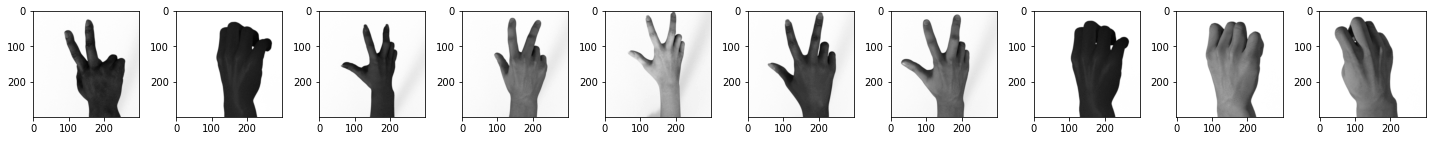

In [2]:
def plot_images(images):
    fig = plt.figure(tight_layout='auto', figsize=(20, 7))
    for i, img in enumerate(images):
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(img, cmap="gray")
    return fig

plot_images(train_images[0:10])
pass

## Part 2: FNN Creation, Training, and Optimization

Your task is to create the best FNN model you can to make "rock paper scissors" predictions.

There are a few rules:

0. You must use the **Functional API** to create the models
1. You must try at least 3 different architectures with different numbers of hidden layers and different numbers of nodes per layer
2. You must try at least 2 of the following methods of reducing overfitting
    * Dropout
    * Regularization
    * Training set augmentation
3. You must try at least 2 different values for each of 2 different hyperparameters from the following list:
    * Kernel initializer 
    * Dropout rate
    * Regularization penalty
4. You must NOT train on the test data (only use the training and validation data for this part of the lab)

This means that you will be performing at least 9 different model creation and trainings with the goal of selecting the model with the best **validation** accuracy. Note that you can tell `.fit()` what validation data to use with the keyword argument `validation_data=(val_images, val_labels)` INSTEAD of using `validation_split`. 

Place the code for each of these model creation and training attempts into separate cells below. 

In [3]:
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="relu")(norm_layer)
h2 = ks.layers.Dense(64, activation="relu")(h1)
h3 = ks.layers.Dense(128, activation="relu")(h2)

output_layer = ks.layers.Dense(3, activation="softmax")(h3)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 90000)             360000    
_________________________________________________________________
dense (Dense)                (None, 255)               22950255  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16384     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387   

In [4]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=20, batch_size=100, validation_split=0.15)

Epoch 1/20
19/19 [==============================] - 6s 260ms/step - loss: 16.8213 - accuracy: 0.6063 - val_loss: 2126.7734 - val_accuracy: 0.3758
Epoch 2/20
19/19 [==============================] - 4s 208ms/step - loss: 1.2238 - accuracy: 0.9383 - val_loss: 671.3974 - val_accuracy: 0.3168
Epoch 3/20
19/19 [==============================] - 4s 217ms/step - loss: 3.3223 - accuracy: 0.8996 - val_loss: 2396.8884 - val_accuracy: 0.3758
Epoch 4/20
19/19 [==============================] - 4s 211ms/step - loss: 1.1696 - accuracy: 0.9588 - val_loss: 2497.8547 - val_accuracy: 0.3758
Epoch 5/20
19/19 [==============================] - 4s 221ms/step - loss: 0.6445 - accuracy: 0.9756 - val_loss: 408.5214 - val_accuracy: 0.5155
Epoch 6/20
19/19 [==============================] - 4s 211ms/step - loss: 0.4352 - accuracy: 0.9858 - val_loss: 837.7751 - val_accuracy: 0.3758
Epoch 7/20
19/19 [==============================] - 4s 210ms/step - loss: 1.1933 - accuracy: 0.9624 - val_loss: 1511.5978 - val_accu

***Model 2***

In [5]:
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="relu")(norm_layer)
h2 = ks.layers.Dense(128, activation="relu")(h1)
h3 = ks.layers.Dense(64, activation="relu")(h2)

output_layer = ks.layers.Dense(3, activation="softmax")(h3)

model2 = ks.Model(inputs=input_layer, outputs=output_layer)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300)]        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 90000)             360000    
_________________________________________________________________
dense_4 (Dense)              (None, 255)               22950255  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32768     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195 

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model2.fit(train_images, train_labels, epochs=20, batch_size=100, validation_split=0.15)

***Model 3***

In [ ]:

input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="relu", kernel_initializer="he_normal")(norm_layer)
h2 = ks.layers.Dense(128, activation="elu", kernel_initializer="he_normal")(h1)
h3 = ks.layers.Dense(64, activation="elu", kernel_initializer="he_normal")(h2)
h4 = ks.layers.Dense(32, activation="elu", kernel_initializer="he_normal")(h3)

output_layer = ks.layers.Dense(3, activation="softmax")(h4)

model3 = ks.Model(inputs=input_layer, outputs=output_layer)
model3.summary()

model3.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model3.fit(images, train_labels, epochs=20, batch_size=200, validation_split=0.15)

In [ ]:

input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="elu", kernel_initializer="he_normal")(norm_layer)
h2 = ks.layers.Dense(128, activation="elu", kernel_initializer="he_normal")(h1)
h3 = ks.layers.Dense(64, activation="elu", kernel_initializer="he_normal")(h2)
h4 = ks.layers.Dense(32, activation="elu", kernel_initializer="he_normal")(h3)

output_layer = ks.layers.Dense(3, activation="softmax")(h4)

model3 = ks.Model(inputs=input_layer, outputs=output_layer)
model3.summary()


In [ ]:
model3.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model3.fit(images, train_labels, epochs=20, batch_size=200, validation_split=0.15)

In [ ]:
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="elu", kernel_regularizer='l1')(norm_layer)
h2 = ks.layers.Dense(128, activation="elu", kernel_regularizer='l1')(h1)
h3 = ks.layers.Dense(64, activation="elu", kernel_regularizer='l1')(h2)

output_layer = ks.layers.Dense(3, activation="softmax")(h3)

model4 = ks.Model(inputs=input_layer, outputs=output_layer)
model4.summary()

In [ ]:
model4.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=4, restore_best_weights=True)

model4.fit(train_images, train_labels, batch_size=100, epochs=15, validation_split=0.15, callbacks=[early_stopping_callback])

In [ ]:
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="elu", kernel_initializer="he_normal")(norm_layer)
h2 = ks.layers.Dense(128, activation="elu", kernel_initializer="he_normal")(h1)
h3 = ks.layers.Dense(64, activation="elu", kernel_initializer="he_normal")(h2)


output_layer = ks.layers.Dense(3, activation="softmax")(h3)



model5 = ks.Model(inputs=input_layer, outputs=output_layer)
model5.summary()



In [ ]:
model5.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

model5.fit(train_images, train_labels, batch_size=100, epochs=15, validation_split=0.15, callbacks=[early_stopping_callback])

In [7]:
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="elu", kernel_initializer="he_normal")(norm_layer)
h1 = ks.layers.Dropout(rate=0.2)(h1)
h2 = ks.layers.Dense(128, activation="elu", kernel_initializer="he_normal")(h1)
h2 = ks.layers.Dropout(rate=0.2)(h2)
h3 = ks.layers.Dense(64, activation="elu", kernel_initializer="he_normal")(h2)
h3 = ks.layers.Dropout(rate=0.2)(h3)

output_layer = ks.layers.Dense(3, activation="softmax")(h3)

model6 = ks.Model(inputs=input_layer, outputs=output_layer)
model6.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300)]        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 90000)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 90000)             360000    
_________________________________________________________________
dense_8 (Dense)              (None, 255)               22950255  
_________________________________________________________________
dropout (Dropout)            (None, 255)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0   

In [9]:
model6.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

model6.fit(train_images, train_labels, batch_size=100, epochs=40, validation_split=0.15)

Epoch 1/40
19/19 [==============================] - 5s 240ms/step - loss: 29.4352 - accuracy: 0.6074 - val_loss: 10667.8994 - val_accuracy: 0.3758
Epoch 2/40
19/19 [==============================] - 4s 209ms/step - loss: 6.1683 - accuracy: 0.8072 - val_loss: 3844.9395 - val_accuracy: 0.3758
Epoch 3/40
19/19 [==============================] - 4s 213ms/step - loss: 5.9507 - accuracy: 0.8716 - val_loss: 4291.3633 - val_accuracy: 0.3230
Epoch 4/40
19/19 [==============================] - 4s 208ms/step - loss: 3.4342 - accuracy: 0.9116 - val_loss: 5165.2583 - val_accuracy: 0.3168
Epoch 5/40
19/19 [==============================] - 4s 211ms/step - loss: 3.1612 - accuracy: 0.9368 - val_loss: 3350.2476 - val_accuracy: 0.3292
Epoch 6/40
19/19 [==============================] - 4s 216ms/step - loss: 1.3795 - accuracy: 0.9570 - val_loss: 2086.4883 - val_accuracy: 0.3758
Epoch 7/40
19/19 [==============================] - 4s 211ms/step - loss: 2.1936 - accuracy: 0.9552 - val_loss: 2494.8828 - val_

In [ ]:
#new dropout rate model 7
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="elu", kernel_initializer="he_normal")(norm_layer)
h1 = ks.layers.Dropout(rate=0.5)(h1)
h2 = ks.layers.Dense(128, activation="elu", kernel_initializer="he_normal")(h1)
h2 = ks.layers.Dropout(rate=0.5)(h2)
h3 = ks.layers.Dense(64, activation="elu", kernel_initializer="he_normal")(h2)
h3 = ks.layers.Dropout(rate=0.5)(h3)

output_layer = ks.layers.Dense(3, activation="softmax")(h3)

model7 = ks.Model(inputs=input_layer, outputs=output_layer)
model7.summary()

In [ ]:
model7.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model7.fit(train_images, train_labels, batch_size=100, epochs=30, validation_split=0.15)

In [ ]:
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="elu", kernel_initializer="random_normal")(norm_layer)
h1 = ks.layers.Dropout(rate=0.2)(h1)
h2 = ks.layers.Dense(128, activation="elu", kernel_initializer="random_normal")(h1)
h2 = ks.layers.Dropout(rate=0.2)(h2)
h3 = ks.layers.Dense(64, activation="elu", kernel_initializer="random_normal")(h2)
h3 = ks.layers.Dropout(rate=0.2)(h3)

output_layer = ks.layers.Dense(3, activation="softmax")(h3)

model8 = ks.Model(inputs=input_layer, outputs=output_layer)
model8.summary()

In [ ]:
model8.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model8.fit(train_images, train_labels, batch_size=100, epochs=30, validation_split=0.15)

In [ ]:
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(255, activation="elu", kernel_regularizer=ks.regularizers.l1(0.001))(norm_layer)
h1 = ks.layers.Dropout(rate=0.2)(h1)
h2 = ks.layers.Dense(128, activation="elu", kernel_regularizer=ks.regularizers.l1(0.001))(h1)
h2 = ks.layers.Dropout(rate=0.2)(h2)
h3 = ks.layers.Dense(64, activation="elu", kernel_regularizer=ks.regularizers.l1(0.001))(h2)
h3 = ks.layers.Dropout(rate=0.2)(h3)

output_layer = ks.layers.Dense(3, activation="softmax")(h3)

model9 = ks.Model(inputs=input_layer, outputs=output_layer)
model9.summary()

In [ ]:
model9.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model9.fit(train_images, train_labels, batch_size=100, epochs=30, validation_split=0.15)

## Part 3: Inspecting Difficult Examples

Your next task is to identify which **test** examples your model classifies incorrectly and inspect enough of these examples to answer the following questions:

0. What is your model's accuracy on the test data?
1. Do the misclassified examples share any similarities that you think might make them more challenging? Explain your reasoning. 
2. Do you think these misclassifications could have been avoided with changes to the data collection process? Explain your reasoning. 
3. Do the misclassified examples surprise you and/or teach you something aboout the classification task you didn't understand at the outset? Explain your reasoning. 

# Submission Instructions
Submit your completed  `Lab7.ipynb` to Gradescope. Be sure to list all of your group members in the submission!
